# Import the required Libraries

In [4]:
import sys
import spotipy
import yaml
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()

In [5]:
sp_df=pd.read_csv('Spotify_rollingstone500.csv')


# Identifying columns with misleading data

In [6]:
for column in sp_df:
    no_value=sp_df[column].eq(0).sum()
    if no_value>0:
        print(f'{no_value}   number of value 0 in column {column}')   

1   number of value 0 in column Unnamed: 0
163   number of value 0 in column instrumentalness


In [7]:
# Drop unname and instrumentalness columns
sp_df.drop(sp_df.columns[0], axis=1,inplace=True)
sp_df.drop(columns=['instrumentalness'],inplace=True)
sp_df.shape

(524, 12)

In [8]:
def hist_df(df):
    for column in sp_df:
        if df[column].dtype == np.float64:
           plt.figure(column,figsize=(20,4))
           plt.title(column)
            #print(sp_df[column].dtype)
           sns.histplot(data=df, x=column,bins=50)
            
    #elif pd.api.types.is_string_dtype(sp_df[column]):
        #print(sp_df[column].dtype)
        #plt.figure(column,figsize=(20,4))
        #plt.title(column)
        #fig=sns.countplot(x=column,data=sp_df)

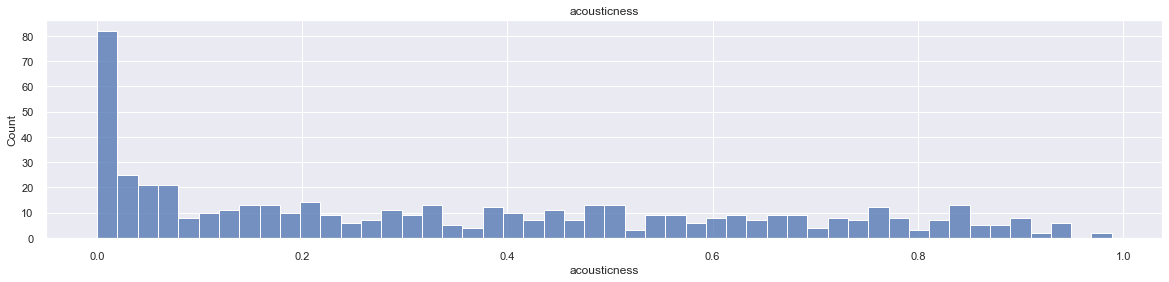

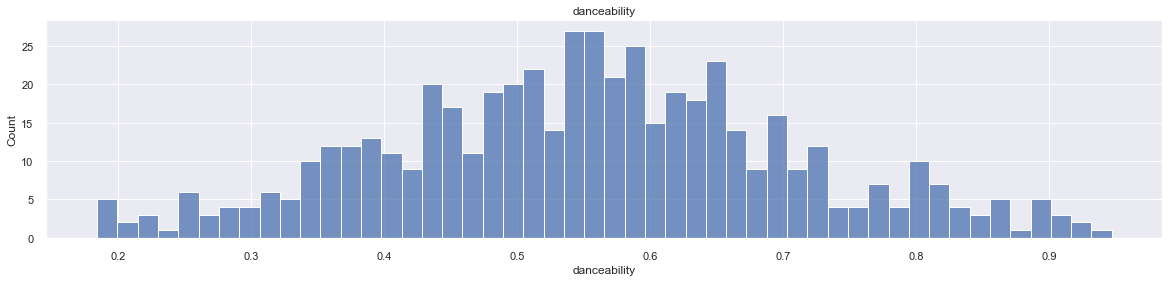

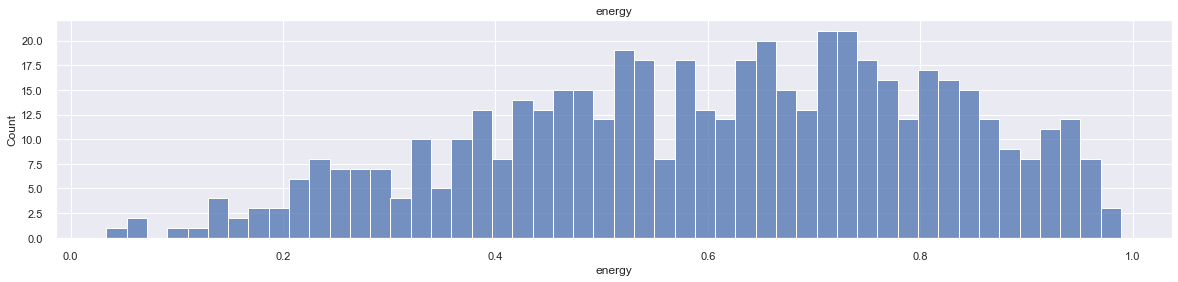

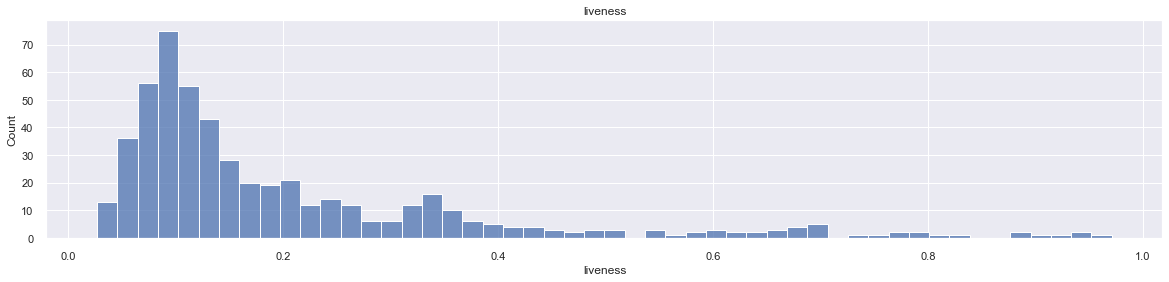

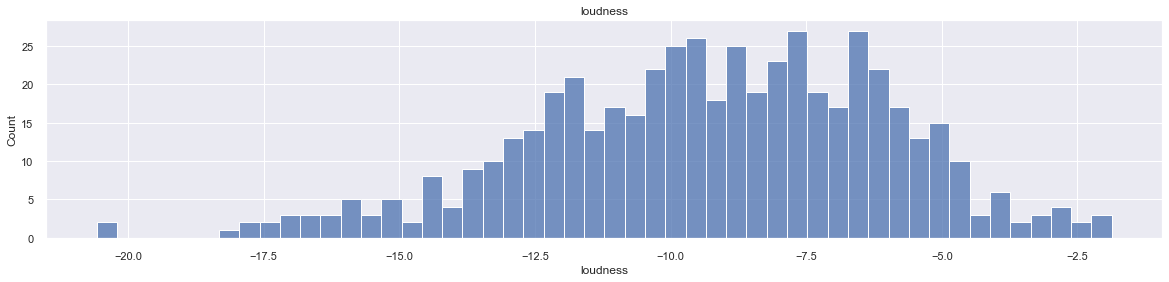

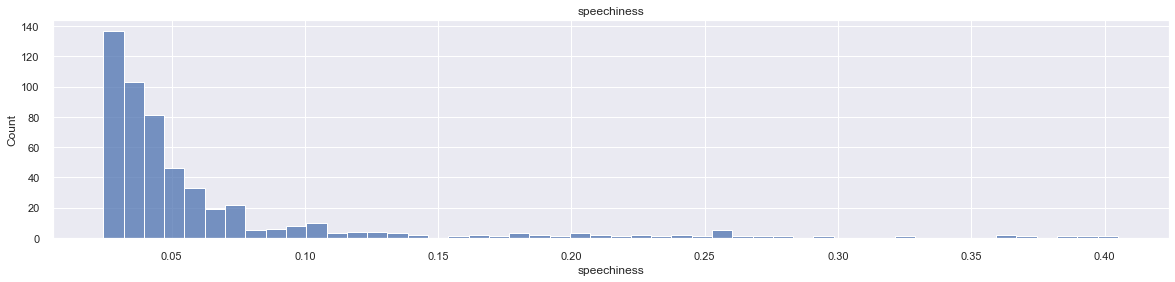

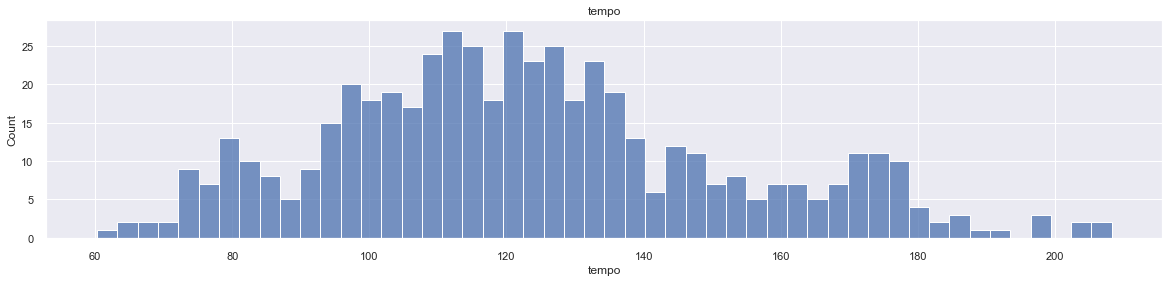

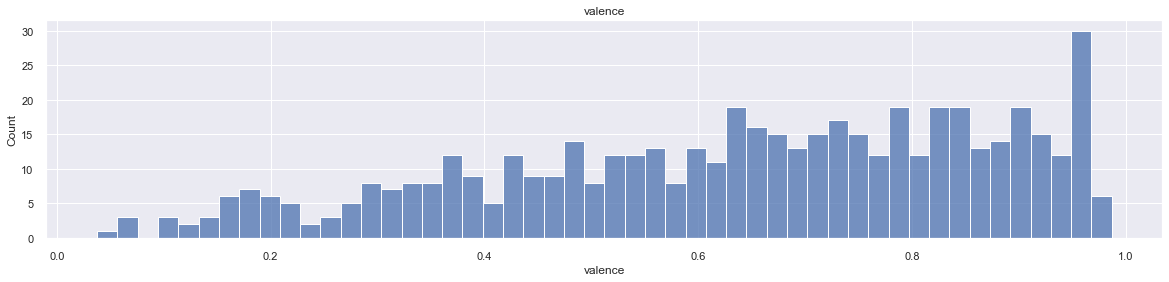

In [9]:
hist_df(sp_df)

# Principal Component Analysis - PCA


In [10]:
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = sp_df[non_features]
df_X = sp_df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence
0,0.7570,0.479,0.704,0.2660,-6.858,0.0334,95.574,0.514
1,0.0348,0.725,0.853,0.1960,-7.842,0.0353,136.282,0.904
2,0.9070,0.547,0.257,0.0935,-12.358,0.0252,75.752,0.169
3,0.4030,0.280,0.720,0.3940,-9.668,0.1110,202.523,0.805
4,0.1500,0.819,0.537,0.0871,-5.223,0.0414,115.086,0.963


In [11]:
scaler = StandardScaler()
sp_df_std = scaler.fit_transform(df_X)

In [12]:
pca = PCA()
pca.fit(sp_df_std);

In [13]:
d_var = pca.explained_variance_ratio_
d_var

array([0.28946799, 0.1776301 , 0.13388005, 0.11810373, 0.11439617,
       0.09242478, 0.04949364, 0.02460354])

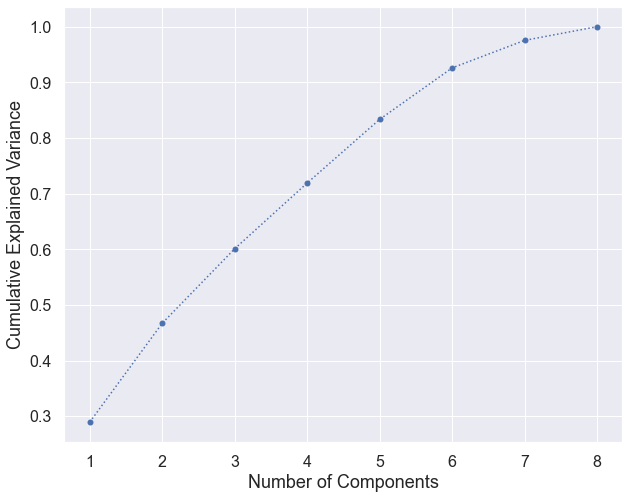

In [14]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), d_var.cumsum(), marker='o', linestyle=':')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [15]:
for i, exp_var in enumerate(d_var.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(sp_df_std)
scores_pca = pca.transform(sp_df_std)

Number of components: 5


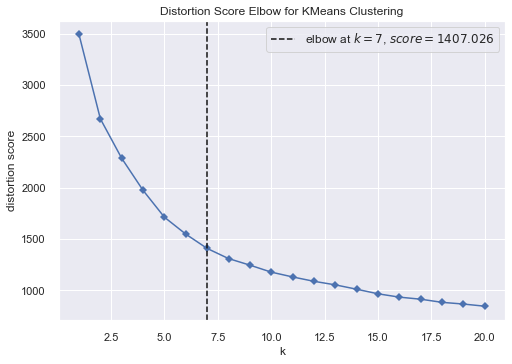

Optimal number of clusters: 7


In [16]:
model_k=KMeans()#(init='k-means++', random_state=42)
visualizer = KElbowVisualizer(model_k, k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [17]:
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)


Optimal number of clusters 7


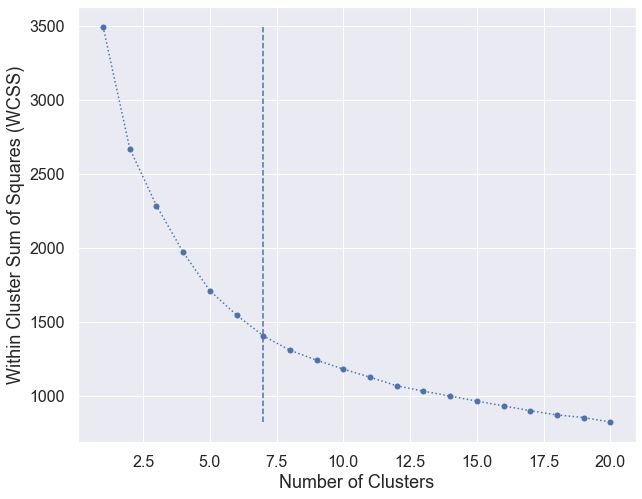

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle=':')
plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig("./visualizations/num_clusters.png")
plt.show()

In [19]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);

In [20]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster
0,0.7570,0.479,0.704,0.2660,-6.858,0.0334,95.574,0.514,0.368806,0.437115,0.978840,-0.674395,-0.176569,6
1,0.0348,0.725,0.853,0.1960,-7.842,0.0353,136.282,0.904,-1.888542,-0.673286,-0.716024,-0.654628,-0.377753,3
2,0.9070,0.547,0.257,0.0935,-12.358,0.0252,75.752,0.169,3.376616,-0.486554,1.122924,0.214619,-0.679969,4
3,0.4030,0.280,0.720,0.3940,-9.668,0.1110,202.523,0.805,-0.817926,2.251205,-1.372151,0.251579,2.278422,1
4,0.1500,0.819,0.537,0.0871,-5.223,0.0414,115.086,0.963,-1.285864,-1.869277,-0.572351,-0.690588,-0.664590,3


/Users/python/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


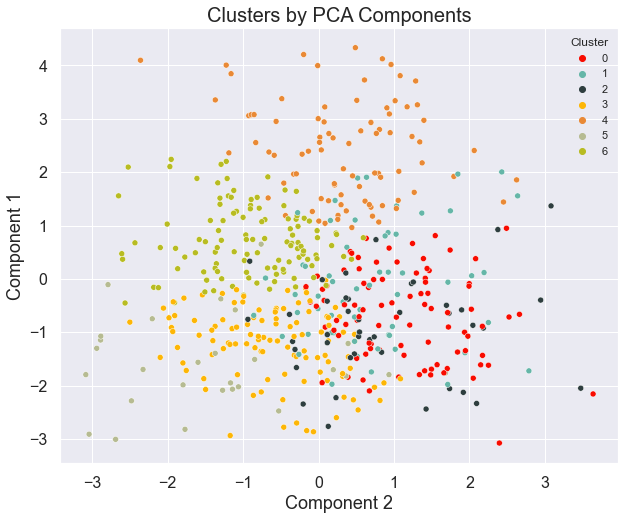

In [21]:
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
flatui = ["#F80B00", "#65B6A8", "#2E3E3F", "#FDB606", "#E98935", "#B6BB92","#B8BC22"]
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette = flatui)
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
#fig.savefig("./visualizations/clusters-2d.png")


In [22]:
sp_df['Cluster'] = df_seg_pca_kmeans['Cluster']
sp_df

,name,artist,track_URI,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
0,Like A Rolling Stone,Bob Dylan,spotify:track:4hR2PmKODnlFa5fe8iWzeo,0.75700,0.479,0.704,0.2660,-6.858,0.0334,95.574,0.514,500 Greatest songs of all time by Rolling ston...,6
1,(I Can't Get No) Satisfaction - Mono Version /...,The Rolling Stones,spotify:track:7fSGbZLhWlAiCC3HDPAULu,0.03480,0.725,0.853,0.1960,-7.842,0.0353,136.282,0.904,500 Greatest songs of all time by Rolling ston...,3
2,Imagine - Remastered 2010,John Lennon,spotify:track:7pKfPomDEeI4TPT6EOYjn9,0.90700,0.547,0.257,0.0935,-12.358,0.0252,75.752,0.169,500 Greatest songs of all time by Rolling ston...,4
3,What's Going On,Marvin Gaye,spotify:track:42PyxnviKRfOa8z39g8aZj,0.40300,0.280,0.720,0.3940,-9.668,0.1110,202.523,0.805,500 Greatest songs of all time by Rolling ston...,1
4,Respect,Aretha Franklin,spotify:track:3OYh9wHWqWD6bpmO3WQNlM,0.15000,0.819,0.537,0.0871,-5.223,0.0414,115.086,0.963,500 Greatest songs of all time by Rolling ston...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,Ignition - Remix,R. Kelly,spotify:track:5dNfHmqgr128gMY2tc5CeJ,0.06100,0.795,0.523,0.0914,-7.165,0.0423,133.024,0.855,500 Greatest songs of all time by Rolling ston...,3
520,The Rising,Bruce Springsteen,spotify:track:2czBvzOv3TvnyoW7Ozo7fP,0.06550,0.499,0.761,0.0895,-6.381,0.0324,110.186,0.326,500 Greatest songs of all time by Rolling ston...,0
521,Shop Around,The Miracles,spotify:track:6dHAIIaTDAY8Wmh6sQ1lX9,0.69200,0.549,0.703,0.6750,-4.923,0.0291,132.082,0.908,500 Greatest songs of all time by Rolling ston...,2
522,Rock Lobster (Single Version),The B-52's,spotify:track:0tACWEElJ2uC47STmG3wVq,0.00788,0.562,0.960,0.0501,-3.848,0.0605,90.308,0.555,500 Greatest songs of all time by Rolling ston...,0


In [23]:
def make_normalized_df(df):
    non_features = df.select_dtypes(include=['object'])
    features = df.select_dtypes(include=['float64'])
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = features.columns)
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = sp_df['Cluster']
orig = sp_df.drop(columns=['playlist', 'Cluster'])
values_df = make_normalized_df(orig)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,name,artist,track_URI,cluster,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence
0,Like A Rolling Stone,Bob Dylan,spotify:track:4hR2PmKODnlFa5fe8iWzeo,6,0.765416,0.386632,0.701633,0.252941,0.733180,0.023647,0.238367,0.501738
1,(I Can't Get No) Satisfaction - Mono Version /...,The Rolling Stones,spotify:track:7fSGbZLhWlAiCC3HDPAULu,3,0.035171,0.709043,0.857621,0.178764,0.680554,0.028639,0.513454,0.912567
2,Imagine - Remastered 2010,John Lennon,spotify:track:7pKfPomDEeI4TPT6EOYjn9,4,0.917087,0.475754,0.233668,0.070149,0.439031,0.002102,0.104418,0.138312
3,What's Going On,Marvin Gaye,spotify:track:42PyxnviKRfOa8z39g8aZj,1,0.407473,0.125819,0.718384,0.388577,0.582897,0.227535,0.961083,0.808280
4,Respect,Aretha Franklin,spotify:track:3OYh9wHWqWD6bpmO3WQNlM,3,0.151654,0.832241,0.526801,0.063368,0.820623,0.044666,0.370221,0.974718


In [24]:
fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'polar'}]*4]*2,horizontal_spacing = 0.1)

angles = list(values_df.columns[4:])
angles.append(angles[0])
abbrev = ["Act", "Dnc", "Eng", "Li", "Lo", "Sp", "Te", "Va"]

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=abbrev,
        fill='toself',
        name="Playlist " + str(i)),
        i // 4 + 1,
        i % 4 + 1)
    
fig.update_layout(
        polar=layoutdict,
        polar2=layoutdict,
        polar3=layoutdict,
        polar4=layoutdict,
        polar5=layoutdict,
        polar6=layoutdict,
        polar7=layoutdict,
        #polar8=layoutdict,
        showlegend=True
        )
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.001,
    xanchor="right",
    x=1
))
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

In [25]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Playlist " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')


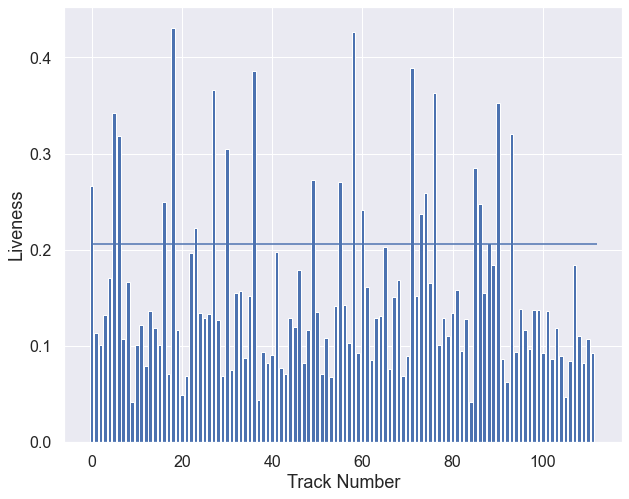

In [26]:

def cluster_plot(df, param, cluster):
    plt.figure(figsize=(10,8))
    test_cluster = df.loc[df['Cluster'] == cluster]
    y = test_cluster[param]
    x = [i for i in range(len(y))]
    plt.bar(x, y)
    plt.xlabel('Track Number', fontsize=18)
    plt.ylabel(param.title(), fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.hlines(np.mean(df[param]), 0, len(y))
    plt.show()
    
cluster_plot(sp_df, "liveness", 6)

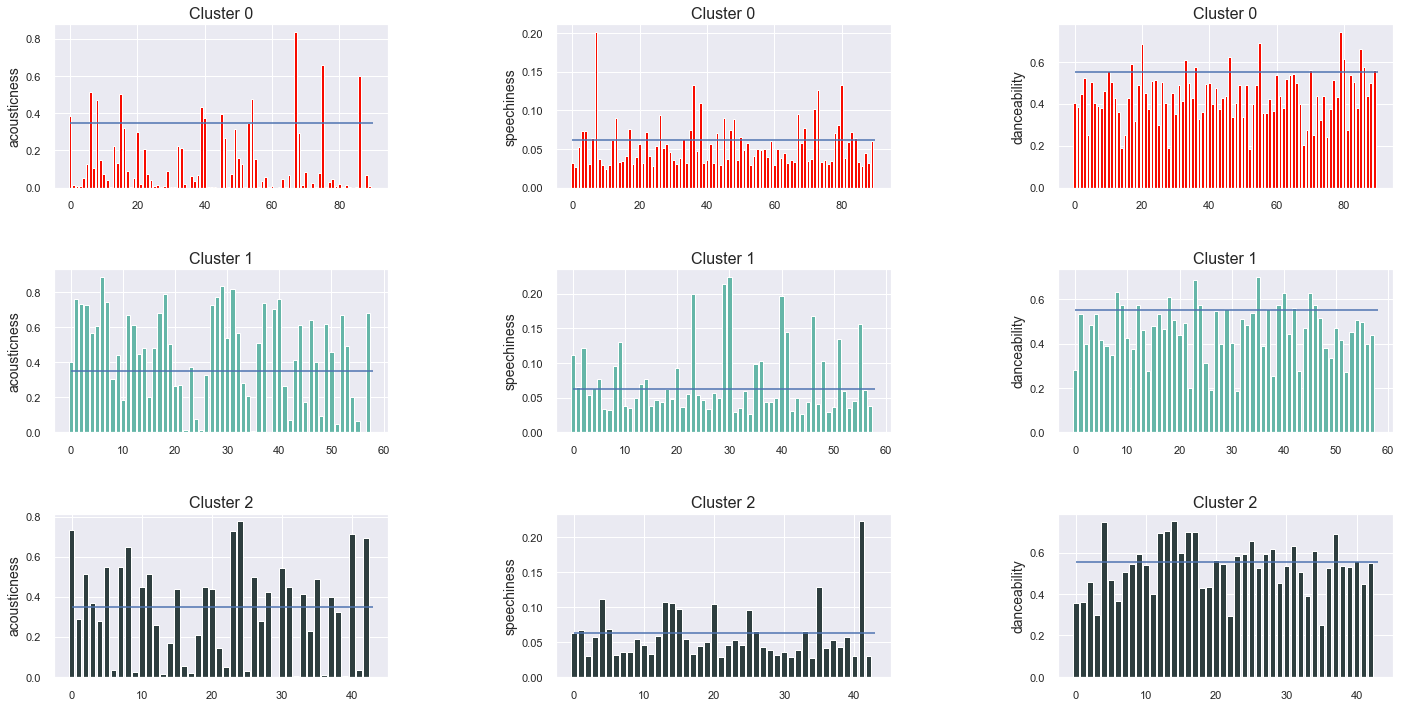

In [27]:
clusters = [0, 1, 2]
features = ["acousticness", "speechiness", "danceability"]
colors = ['tab:green', 'tab:olive', 'tab:cyan']
dim = len(clusters)

fig, axes = plt.subplots(dim, dim, figsize=(24, 12))
i = 0
f = 0
test_cluster = sp_df.loc[sp_df['Cluster'] == clusters[0]]
for ax in (axes.flatten()):
    if i % dim == 0 and i != 0:
        test_cluster = sp_df.loc[sp_df['Cluster'] == clusters[i // dim]]
    
    col = features[i % dim]
    y = test_cluster[col]
    x = [i for i in range(len(y))]
    ax.bar(x, y, color=flatui[i//dim])
    ax.set_ylabel(col, fontsize=14)
    ax.set_title("Cluster " + str(clusters[i // dim]), fontsize=16)
    ax.hlines(np.mean(sp_df[col]), 0, len(y))
    plt.subplots_adjust(wspace=.5, hspace=.5)
    i += 1
    
#fig.savefig("./visualizations/cluster_feature_bar_charts_dim_3.png")

In [28]:
sp_df.columns

Index(['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist',
       'Cluster'],
      dtype='object')

In [29]:
names=['name', 'artist', 'track_URI']

for c in sp_df.Cluster.unique():
    cl = sp_df.loc[sp_df['Cluster'] == c]
    cl = pd.DataFrame(cl, columns=names)
    exec(f'cluster{c} = cl')

#cluster2 = sp_df.loc[sp_df['Cluster'] == 2]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster3 = sp_df.loc[sp_df['Cluster'] == 3]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster4 = sp_df.loc[sp_df['Cluster'] == 4]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster5 = sp_df.loc[sp_df['Cluster'] == 5]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster6 = sp_df.loc[sp_df['Cluster'] == 6]
#cluster1 = pd.DataFrame(cluster1, columns=names)


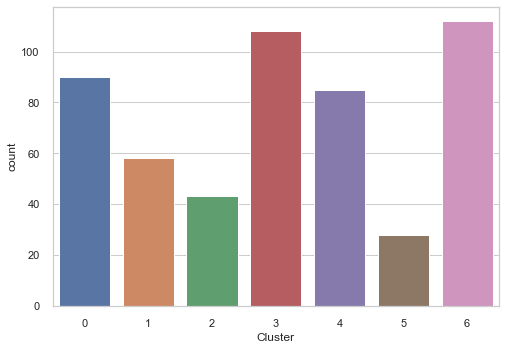

In [47]:

sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Cluster", data=sp_df)


# Suggestions

#### compairing each clusters by their properties with consistant Y axis
#### tsne
#### umap
#### recomendation cluster
#### check distance to the others
